In [1]:
import pandas as pd
import networkx as nx
import itertools

In [2]:

file_path = 'Liguori_translations_FR_normalized_publishers_translators_places.xlsx'
df = pd.read_excel(file_path)

In [3]:
import math

In [4]:

G_1850_75 = nx.MultiDiGraph()

# Function to extract and sort years chronologically
# For this period we had to tweak the function so that in cases of subsequent editions entered as
# e.g., 1868-1892 it extracts in this case all years between 1868 and 1875
def extract_years(row, cutoff_year0, cutoff_year1):
    year = row['First ed.']
    subsequent = row['Subsq. ed.']
    
    all_years = []
    
    # Check and add 'First ed.' year if within the interval
    if not math.isnan(year) and cutoff_year0 < int(year) <= cutoff_year1:
        all_years.append(int(year))
    
    # Process 'Subsq. ed.' column
    if isinstance(subsequent, str):
        subsequent_years = []
        for entry in subsequent.split(','):
            entry = entry.strip()
            if '-' in entry:  # Detect ranges like '1868-1892'
                try:
                    start, end = map(int, entry.split('-'))
                    # Add years within the range that fit the cutoff
                    subsequent_years.extend(
                        year for year in range(start, end + 1)
                        if cutoff_year0 < year <= cutoff_year1
                    )
                except ValueError:
                    # Handle malformed ranges gracefully
                    continue
            else:  # Single year entry
                try:
                    year = int(entry.split()[0])  # Extract year from single entry
                    if cutoff_year0 < year <= cutoff_year1:
                        subsequent_years.append(year)
                except ValueError:
                    continue
        
        all_years.extend(subsequent_years)
    
    # Sort the final list of years
    all_years = sorted(all_years)
    
    return all_years



def is_valid_year(x):
    try:
        year_int = int(x)
        return 1850 < year_int and year_int <= 1875
    except ValueError:
        return False
    

filtered_df = df[df['First ed.'].apply(lambda x: x if not (math.isnan(x) or not is_valid_year(x)) else None).notna()]

unique_publishers = set()

for publishers in filtered_df['Normalized Publisher']:
    if isinstance(publishers, str):
        unique_publishers.update([publisher.strip() for publisher in publishers.split(';')])
    else:
        unique_publishers.update([publishers])

for publisher in unique_publishers:
    G_1850_75.add_node(publisher, publications=[])
    

for index, row in filtered_df.iterrows():
    title = row['Title']
    years = extract_years(row, 1850, 1875)
    editions = sum(1 for year in years) if years != [] else 0  # Calculate number of editions based on years after 1850 through to 1875
    publishers = [publisher.strip() for publisher in row['Normalized Publisher'].split('; ')] if isinstance(row['Normalized Publisher'], str) else [row['Normalized Publisher']]
    translator = row['Normalized Translator']
    places = [place.strip() for place in row['Publ. place'].split('; ')] if isinstance(row['Publ. place'], str) else [str(row['Publ. place']).strip()]

    for publisher in unique_publishers:
        if publisher in publishers:
            G_1850_75.nodes[publisher]['publications'].append({
                'title': title,
                'years': years,
                'editions': [editions],
                'publisher': publishers,
                'translator': translator,
                'place': places
            })


for publisher in G_1850_75.nodes():
    if 'publications' in G_1850_75.nodes[publisher]:  # Check if 'publications' key exists
        magnitude = sum(pub['editions'][0] for pub in G_1850_75.nodes[publisher]['publications'])
        G_1850_75.nodes[publisher]['magnitude'] = magnitude

In [5]:
len(G_1850_75.nodes)

62

In [12]:

nodes_with_sizes = [(publisher, data['magnitude']) for publisher, data in G_1850_75.nodes(data=True) if 'magnitude' in data]

sorted_nodes = sorted(nodes_with_sizes, key=lambda x: x[1], reverse=True)

for publisher, size in sorted_nodes:
    print(f"Publisher: {publisher}, Size: {size}")

Publisher: casterman, Size: 53
Publisher: ardant, Size: 40
Publisher: mame, Size: 31
Publisher: plagaud, Size: 25
Publisher: nan, Size: 13
Publisher: barbou, Size: 10
Publisher: thibaut, Size: 7
Publisher: perisse, Size: 7
Publisher: ruffet, Size: 7
Publisher: lefort, Size: 6
Publisher: lecoffre, Size: 6
Publisher: pellion, Size: 6
Publisher: mgard, Size: 5
Publisher: cornillac, Size: 5
Publisher: thibaud, Size: 5
Publisher: kittler, Size: 5
Publisher: laroche, Size: 4
Publisher: lethielleux, Size: 4
Publisher: mulo, Size: 3
Publisher: gaume, Size: 3
Publisher: nicolle, Size: 2
Publisher: librairie internationale catholique, Size: 2
Publisher: curnier, Size: 2
Publisher: peltier, Size: 2
Publisher: clermont librairie catholique, Size: 1
Publisher: girard, Size: 1
Publisher: douniol, Size: 1
Publisher: prosper trenel, Size: 1
Publisher: bibliothque populaire, Size: 1
Publisher: rouget, Size: 1
Publisher: palm, Size: 1
Publisher: larumbe, Size: 1
Publisher: bureau de labeille, Size: 1
Pu

In [6]:

def add_edge_with_attributes(G, publisher_A, publisher_B, title, source_years, target_years,
                             source_translator, target_translator, source_num_editions,
                             target_num_editions, source_place, target_place, weight, relation, key):
    G.add_edge(publisher_A, publisher_B, title=title, source_years=source_years, target_years=target_years,
               source_translator=source_translator, target_translator=target_translator,
               source_num_editions=source_num_editions, target_num_editions=target_num_editions,
               source_place=source_place, target_place=target_place, weight=weight, relation=relation, key=key)

In [7]:
existing_edges = set()

# Function to add edges between publishers with support for multiple edges of the same type
def add_edges_between_publishers(G):
    for pub_A, pub_B in itertools.combinations(G.nodes, 2):  # Iterate over pairs of nodes
        publications_A = G.nodes[pub_A]['publications']
        publications_B = G.nodes[pub_B]['publications']
        
        # Compare all publications between two publishers
        for publication_A in publications_A:
            for publication_B in publications_B:
                title_A, title_B = publication_A['title'], publication_B['title']
                years_A, years_B = publication_A['years'], publication_B['years']
                editions_A, editions_B = publication_A['editions'], publication_B['editions']
                translators_A, translators_B = publication_A['translator'], publication_B['translator']
                publishers_A, publishers_B = set(publication_A['publisher']), set(publication_B['publisher'])
                
                # Ensure translators_A and translators_B are lists
                translators_A = translators_A if isinstance(translators_A, list) else []
                translators_B = translators_B if isinstance(translators_B, list) else []

                
                # Initialize edge counters
                edge_counter = 0

                # Check for copublication
                if (len(publishers_A) == 1 & len(publishers_B) == 1) and title_A == title_B and set(years_A) == set(years_B):
                    # Create a unique edge key
                    edge_counter = sum(1 for key in existing_edges if f"copub_{pub_A}_{pub_B}_" in key) + 1
                    edge_key = f"copub_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                    # Check if the edge already exists
                    if edge_key not in existing_edges:
                        weight = max(editions_A[0], editions_B[0])
                        add_edge_with_attributes(
                            G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                            editions_A, editions_B, publication_A['place'], publication_B['place'],
                            weight, 'copublication', edge_key
                        )
                        existing_edges.add(edge_key)

                # Check for reprint relation
                if set(translators_A) == set(translators_B) and title_A == title_B and years_A and years_B:
                    if len(years_A) > 0 and len(years_B) > 0:
                        if years_A[0] < years_B[0] and publishers_A != publishers_B:
                            edge_counter += 1
                            edge_key = f"reprint_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                            # Check if the edge already exists
                            if edge_key not in existing_edges:
                                weight = editions_B[0]
                                add_edge_with_attributes(
                                    G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                                    editions_A, editions_B, publication_A['place'], publication_B['place'],
                                    weight, 'reprint', edge_key
                                )
                                existing_edges.add(edge_key)

                # Check for retranslation relation
                if set(translators_A) != set(translators_B) and title_A == title_B and years_A and years_B:
                    if len(years_A) > 0 and len(years_B) > 0:
                        if years_A[0] < years_B[0] and publishers_A != publishers_B:
                            edge_counter += 1
                            edge_key = f"retrans_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                            # Check if the edge already exists
                            if edge_key not in existing_edges:
                                weight = editions_B[0]
                                add_edge_with_attributes(
                                    G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                                    editions_A, editions_B, publication_A['place'], publication_B['place'],
                                    weight, 'retranslation', edge_key
                                )
                                existing_edges.add(edge_key)

In [8]:

add_edges_between_publishers(G_1850_75)

In [11]:
len(G_1839_50.edges)

272

In [9]:
len(G_1850_75.edges)

272

In [52]:
len(existing_edges) # G_thru_1825

471

In [16]:
len(existing_edges) # G_1826_38

550

In [12]:
len(existing_edges) # G_1839_50

272

In [10]:
len(existing_edges) # G_1850_75

272

In [18]:

for title, first_ed, subsq_ed, edition, publisher, translator, place in zip(
        filtered_df['Title'],
        filtered_df['First ed.'],
        filtered_df['Subsq. ed.'],
        filtered_df['Editions'],
        filtered_df['Normalized Publisher'],
        filtered_df['Normalized Translator'],
        filtered_df['Publ. place']
    ):
    
    publisher_list = [pub.strip() for pub in str(publisher).split(';') if pub.strip()]
    
    translator_list = [trans.strip() for trans in str(translator).split(';') if trans.strip()]
    
    place_list = [pl.strip() for pl in str(place).split(';') if pl.strip()]
    
    if len(publisher_list) > 1:
        
        for pub_A, pub_B in itertools.combinations(publisher_list, 2):
            # Assign a weight based on editions
            weight = max(edition, edition)
            # Generate a unique edge key for each copublication instance
            edge_counter = sum(1 for key in existing_edges if f"copub_{pub_A}_{pub_B}_" in key) + 1
            edge_key = f"copub_{pub_A}_{pub_B}_{title}_{edge_counter}"

            # Check if the edge already exists
            if edge_key not in existing_edges:
                add_edge_with_attributes(
                    G_1850_75, pub_A, pub_B, title, [first_ed, subsq_ed], [first_ed, subsq_ed], translator_list, translator_list,
                    [edition], [edition], place_list, place_list, weight, 'copublication', edge_key
                )
                existing_edges.add(edge_key)


In [19]:

out_degrees = dict(G_1850_75.out_degree())
in_degrees = dict(G_1850_75.in_degree())
overall_degrees = {node: out_degrees.get(node, 0) + in_degrees.get(node, 0) for node in G_1850_75.nodes()}

nodes_by_out_degree = sorted(out_degrees, key=out_degrees.get, reverse=True)
nodes_by_in_degree = sorted(in_degrees, key=in_degrees.get, reverse=True)
nodes_by_overall_degree = sorted(overall_degrees, key=overall_degrees.get, reverse=True)

print("Nodes ordered by outgoing degree:")
for node in nodes_by_out_degree:
    print(node, out_degrees[node])

print("\nNodes ordered by incoming degree:")
for node in nodes_by_in_degree:
    print(node, in_degrees[node])

print("\nNodes ordered by overall degree:")
for node in nodes_by_overall_degree:
    print(node, overall_degrees[node])

Nodes ordered by outgoing degree:
ardant 33
mgard 32
plagaud 27
cornillac 21
lefort 18
fonteney 17
thibaud 17
guyot 14
librairie universelle 12
lecoffre 12
rouget 11
curnier 10
peltier 9
pellion 8
nan 7
casterman 7
laroche 5
mame 5
thibaut 4
mulo 4
popelain 3
oudin 3
barets 2
librairie internationale catholique 2
kittler 2
barbou 2
vimont 2
girard 1
prosper trenel 1
bouquerel 1
deligne 1
briez 1
delahaut 1
lethielleux 1
clermont librairie catholique 0
douniol 0
bibliothque populaire 0
palm 0
larumbe 0
bureau de labeille 0
nicolle 0
le mle 0
benziger 0
lvche 0
beauchne 0
gaume 0
bitsch 0
hattu 0
goemaere 0
librairie catholique 0
les religieuses de saintjoseph 0
mollie 0
perisse 0
biarns 0
lejeune 0
desbenoit 0
dechrist 0
société de saintvictor 0
sarlit 0
vignancour 0
gallienne 0
ruffet 0

Nodes ordered by incoming degree:
ruffet 27
barbou 24
mame 20
sarlit 20
pellion 18
delahaut 16
peltier 15
curnier 14
casterman 14
thibaut 12
oudin 12
vimont 12
lefort 10
barets 8
kittler 8
lecoffre 8
m

In [20]:


weights = []

outgoing_weighted_degrees = {}
incoming_weighted_degrees = {}
overall_weighted_degrees = {}

for node in G_1850_75.nodes():
    successors = []
    for node_id in G_1850_75.successors(node):
        successors.append(node_id)
    weights = []
    for u, v, key, attr in G_1850_75.edges(keys=True, data=True):
        if (u in successors and v == node) or (u == node and v in successors):
            weight = attr['weight']
            #weights.append(sum(weight))
            weights.append(weight)
    #outgoing_weight = sum(sum(G11.edges[node, neighbor]['weight']) for neighbor in G11.successors(node))
    outgoing_weighted_degrees[node] = sum(weights)

for node in G_1850_75.nodes():
    predecessors = []
    for node_id in G_1850_75.predecessors(node):
        predecessors.append(node_id)
    weights = []
    for u, v, key, attr in G_1850_75.edges(keys=True, data=True):
        if (u in predecessors and v == node) or (u == node and v in predecessors):
            weight = attr['weight']
            # weights.append(sum(weight))
            weights.append(weight)
    #incoming_weight = sum(sum(G11.edges[neighbor, node]['weight']) for neighbor in G11.predecessors(node))
    incoming_weighted_degrees[node] = sum(weights)

for node in G_1850_75.nodes():
    overall_weighted_degree = outgoing_weighted_degrees.get(node, 0) + incoming_weighted_degrees.get(node, 0)
    overall_weighted_degrees[node] = overall_weighted_degree

sorted_outgoing_weighted_degrees = dict(sorted(outgoing_weighted_degrees.items(), key=lambda item: item[1], reverse=True))
sorted_incoming_weighted_degrees = dict(sorted(incoming_weighted_degrees.items(), key=lambda item: item[1], reverse=True))
sorted_overall_weighted_degrees = dict(sorted(overall_weighted_degrees.items(), key=lambda item: item[1], reverse=True))

print("Outgoing Weighted Degrees:", sorted_outgoing_weighted_degrees)
print("Incoming Weighted Degrees:", sorted_incoming_weighted_degrees)
print("Overall Weighted Degrees:", sorted_overall_weighted_degrees)

Outgoing Weighted Degrees: {'plagaud': 62, 'ardant': 60, 'mgard': 57, 'cornillac': 56, 'lefort': 44, 'casterman': 39, 'fonteney': 35, 'thibaud': 29, 'guyot': 28, 'laroche': 22, 'librairie universelle': 22, 'lecoffre': 22, 'curnier': 20, 'rouget': 19, 'popelain': 19, 'peltier': 19, 'kittler': 17, 'pellion': 8, 'mulo': 6, 'librairie internationale catholique': 6, 'mame': 5, 'thibaut': 4, 'girard': 3, 'bouquerel': 3, 'oudin': 3, 'barets': 2, 'barbou': 2, 'vimont': 2, 'prosper trenel': 1, 'deligne': 1, 'briez': 1, 'delahaut': 1, 'lethielleux': 1, 'clermont librairie catholique': 0, 'douniol': 0, 'bibliothque populaire': 0, 'palm': 0, 'larumbe': 0, 'bureau de labeille': 0, 'nicolle': 0, 'le mle': 0, 'benziger': 0, nan: 0, 'lvche': 0, 'beauchne': 0, 'gaume': 0, 'bitsch': 0, 'hattu': 0, 'goemaere': 0, 'librairie catholique': 0, 'les religieuses de saintjoseph': 0, 'mollie': 0, 'perisse': 0, 'biarns': 0, 'lejeune': 0, 'desbenoit': 0, 'dechrist': 0, 'société de saintvictor': 0, 'sarlit': 0, 'vi

In [21]:

from collections import Counter


source_place_counter = Counter()
target_place_counter = Counter()
overall_place_counter = Counter()


for publisher_A, publisher_B, data in G_1850_75.edges(data=True):
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    
    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]
    
    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            #place_list = [place_list]
            target_places[i] = [place_list]
            
    for place_list in source_places:
        for place in place_list:
            source_place_counter[place] += 1
            
    for place_list in target_places:
        for place in place_list:
            target_place_counter[place] += 1
    
    for place_list in source_places + target_places:
        #if isinstance(place_list, str):
            #place_list = [place_list]  # Convert string to list
        for place in place_list:
            overall_place_counter[place] += 1


sorted_source_places = source_place_counter.most_common()
sorted_target_places = target_place_counter.most_common()
sorted_overall_places = overall_place_counter.most_common()


print("Sorted Source Places:", sorted_source_places)
print("Sorted Target Places:", sorted_target_places)
print("Sorted Overall Places:", sorted_overall_places)

Sorted Source Places: [('Paris', 87), ('Lyon', 52), ('Limoges', 39), ('Rouen', 34), ('Châtillon', 20), ('Clermont', 19), ('Lille', 18), ('Tournai', 16), ('Leipzig', 15), ('Toulouse', 12), ('Dijon', 11), ('Poitiers', 3), ('Bordeaux', 2), ('Saint-Nicolas (Meurthe)', 1), ('Châtillon-sur-Seine', 1), ('Cambrai', 1), ('Tours', 1), ('Abbeville', 1)]
Sorted Target Places: [('Paris', 133), ('Limoges', 39), ('Tournai', 26), ('Lyon', 25), ('Leipzig', 24), ('Dijon', 20), ('Toulouse', 18), ('Poitiers', 12), ('Rouen', 12), ('Lille', 10), ('Bordeaux', 8), ('Tours', 8), ('Clermont', 6), ('Châtillon', 2), ('Le Mans', 2), ('Douai', 1)]
Sorted Overall Places: [('Paris', 220), ('Limoges', 78), ('Lyon', 77), ('Rouen', 46), ('Tournai', 42), ('Leipzig', 39), ('Dijon', 31), ('Toulouse', 30), ('Lille', 28), ('Clermont', 25), ('Châtillon', 22), ('Poitiers', 15), ('Bordeaux', 10), ('Tours', 9), ('Le Mans', 2), ('Saint-Nicolas (Meurthe)', 1), ('Douai', 1), ('Châtillon-sur-Seine', 1), ('Cambrai', 1), ('Abbeville',

In [22]:

source_place_counter_weighted = Counter()
target_place_counter_weighted = Counter()
overall_place_counter_weighted = Counter()

for publisher_A, publisher_B, data in G_1850_75.edges(data=True):
    # Get the weight of the current edge
    weight = data['weight']
    
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]

    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            target_places[i] = [place_list]

    for place_list in source_places:
        for place in place_list:
            # source_place_counter_weighted[place] += weight[0]
            source_place_counter_weighted[place] += weight
            
    for place_list in target_places:
        for place in place_list:
            # target_place_counter_weighted[place] += weight[0]
            target_place_counter_weighted[place] += weight

    for place_list in source_places + target_places:
        for place in place_list:
            # overall_place_counter_weighted[place] += weight[0]
            overall_place_counter_weighted[place] += weight

sorted_source_places_weighted = source_place_counter_weighted.most_common()
sorted_target_places_weighted = target_place_counter_weighted.most_common()
sorted_overall_places_weighted = overall_place_counter_weighted.most_common()

print("Sorted Source Places (Weighted):", sorted_source_places_weighted)
print("Sorted Target Places (Weighted):", sorted_target_places_weighted)
print("Sorted Overall Places (Weighted):", sorted_overall_places_weighted)

Sorted Source Places (Weighted): [('Paris', 197), ('Lyon', 113), ('Limoges', 66), ('Rouen', 59), ('Tournai', 56), ('Châtillon', 55), ('Leipzig', 51), ('Lille', 44), ('Clermont', 33), ('Dijon', 27), ('Toulouse', 20), ('Poitiers', 3), ('Bordeaux', 2), ('Saint-Nicolas (Meurthe)', 1), ('Châtillon-sur-Seine', 1), ('Cambrai', 1), ('Tours', 1), ('Abbeville', 1)]
Sorted Target Places (Weighted): [('Paris', 308), ('Tours', 80), ('Limoges', 75), ('Tournai', 66), ('Leipzig', 60), ('Lille', 26), ('Lyon', 25), ('Dijon', 20), ('Toulouse', 19), ('Poitiers', 12), ('Rouen', 12), ('Bordeaux', 8), ('Châtillon', 6), ('Clermont', 6), ('Le Mans', 2), ('Douai', 1)]
Sorted Overall Places (Weighted): [('Paris', 505), ('Limoges', 141), ('Lyon', 138), ('Tournai', 122), ('Leipzig', 111), ('Tours', 81), ('Rouen', 71), ('Lille', 70), ('Châtillon', 61), ('Dijon', 47), ('Toulouse', 39), ('Clermont', 39), ('Poitiers', 15), ('Bordeaux', 10), ('Le Mans', 2), ('Saint-Nicolas (Meurthe)', 1), ('Douai', 1), ('Châtillon-sur-

In [23]:

# Initialize counters for unweighted and weighted titles
unweighted_title_counter = Counter()
weighted_title_counter = Counter()

# Initialize dictionaries to store concatenated source and target places for each title
title_source_places = {}
title_target_places = {}

# Iterate over edges in the graph
for publisher_A, publisher_B, data in G_1850_75.edges(data=True):
    title = data['title']
    weight = data['weight']
    
    # Increment the unweighted and weighted title counters
    unweighted_title_counter[title] += 1
    weighted_title_counter[title] += weight
    
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]

    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            target_places[i] = [place_list]
    
    if title not in title_source_places:
                title_source_places[title] = [] 
            
    for place_list in source_places:
        for place in place_list:
            title_source_places[title].append(place)
    
    if title not in title_target_places:
                title_target_places[title] = [] 
            
    for place_list in target_places:
        for place in place_list:          
            title_target_places[title].append(place)

# Sort titles based on unweighted occurrences
sorted_unweighted_titles = unweighted_title_counter.most_common()

# Sort titles based on weighted occurrences
sorted_weighted_titles = weighted_title_counter.most_common()

for elem in sorted_unweighted_titles:
    print(f"Title and number of connections between places it occasioned: {elem} | Source Places: {set(title_source_places[elem[0]])} | Target Places: {set(title_target_places[elem[0]])}")

for ele in sorted_weighted_titles:
    print(f"Title and weighted number of connections between places it occasioned: {ele} | Source Places: {set(title_source_places[ele[0]])} | Target Places: {set(title_target_places[ele[0]])}")

Title and number of connections between places it occasioned: ('Visite au S. Sacrement et à\xa0 la Sainte Vierge', 226) | Source Places: {'Toulouse', 'Dijon', 'Châtillon', 'Lyon', 'Limoges', 'Rouen', 'Poitiers', 'Lille', 'Bordeaux', 'Clermont', 'Paris'} | Target Places: {'Toulouse', 'Dijon', 'Châtillon', 'Lyon', 'Limoges', 'Poitiers', 'Rouen', 'Leipzig', 'Lille', 'Tournai', 'Bordeaux', 'Clermont', 'Paris'}
Title and number of connections between places it occasioned: ('Pratique de l\'amour envers Jésus-Christ, tirée des paroles de S. Paul : "Caritas patiens est, benigna est"... par le B. Alphonse de Liguori', 29) | Source Places: {'Dijon', 'Châtillon', 'Lyon', 'Limoges', 'Rouen', 'Tours', 'Lille', 'Paris'} | Target Places: {'Dijon', 'Lyon', 'Limoges', 'Tours', 'Lille', 'Paris'}
Title and number of connections between places it occasioned: ('Paraphrase du "Salve Regina", par le bienheureux Alphonse de Liguori...', 14) | Source Places: {'Clermont', 'Paris', 'Limoges', 'Rouen'} | Target P

In [11]:


G_combined = nx.DiGraph()

for u, v, key, attr in G_1850_75.edges(keys=True, data=True):
    weight = attr.get('weight', 0)  # Default to 0 if 'weight' is missing

    if G_combined.has_edge(u, v):
        G_combined[u][v]['weight'] += weight
    else:
        G_combined.add_edge(u, v, weight=weight)

for node, data in G_1850_75.nodes(data=True):
    if not G_combined.has_node(node):
        G_combined.add_node(node, **data)

In [26]:

len(G_combined.nodes)

62

In [79]:
len(G_combined.edges) # out of the 471 in G_thru_1825 now collapsed into a digraph:

460

In [24]:
len(G_combined.edges) # out of 550 edges in G_1826_38 

529

In [25]:
len(G_combined.edges) # out of 272 edges in G_1839_50

257

In [12]:
len(G_combined.edges) # out of 276 edges in G_1850_75

245

In [28]:

closeness_centralities = nx.closeness_centrality(G_combined)

betweenness_centralities = nx.betweenness_centrality(G_combined)

In [29]:

eigenvector_centralities = nx.eigenvector_centrality(G_combined)

In [85]:
# eigenvector_centralities = nx.eigenvector_centrality(G_combined, max_iter = 500)

In [30]:
import operator

In [31]:

sorted_closeness = sorted(closeness_centralities.items(), key=operator.itemgetter(1), reverse=True)
sorted_betweenness = sorted(betweenness_centralities.items(), key=operator.itemgetter(1), reverse=True)
sorted_eigenvector = sorted(eigenvector_centralities.items(), key=operator.itemgetter(1), reverse=True)

In [32]:
sorted_closeness

[('ruffet', 0.3621460506706409),
 ('sarlit', 0.3372365339578454),
 ('barbou', 0.3173770491803279),
 ('pellion', 0.3012295081967213),
 ('delahaut', 0.2777242044358727),
 ('mame', 0.2655737704918033),
 ('casterman', 0.26557377049180325),
 ('oudin', 0.2333654773384764),
 ('vimont', 0.2333654773384764),
 ('peltier', 0.21697203471552554),
 ('mollie', 0.19726775956284154),
 ('curnier', 0.18900675024108005),
 ('lvche', 0.17606108241634852),
 ('kittler', 0.17574734811957568),
 ('librairie internationale catholique', 0.17072599531615926),
 ('laroche', 0.16832140383283306),
 ('barets', 0.13114754098360656),
 ('lefort', 0.13114754098360656),
 ('lecoffre', 0.13114754098360654),
 (nan, 0.12071535022354694),
 ('mulo', 0.11475409836065574),
 ('thibaud', 0.10928961748633878),
 ('thibaut', 0.09836065573770492),
 ('popelain', 0.08299180327868852),
 ('guyot', 0.07377049180327869),
 ('plagaud', 0.06557377049180328),
 ('fonteney', 0.058548009367681494),
 ('gallienne', 0.036885245901639344),
 ('rouget', 0.0

In [33]:

sorted_betweenness 

[('casterman', 0.02814207650273224),
 ('pellion', 0.020100182149362475),
 ('mame', 0.009471766848816031),
 ('lefort', 0.009262295081967215),
 (nan, 0.005282331511839708),
 ('plagaud', 0.0032513661202185793),
 ('curnier', 0.00302367941712204),
 ('thibaud', 0.0015027322404371586),
 ('kittler', 0.000819672131147541),
 ('peltier', 0.000610200364298725),
 ('barbou', 0.0005009107468123862),
 ('cornillac', 0.0004098360655737705),
 ('ardant', 0.0001366120218579235),
 ('mgard', 0.0),
 ('rouget', 0.0),
 ('fonteney', 0.0),
 ('thibaut', 0.0),
 ('guyot', 0.0),
 ('barets', 0.0),
 ('mulo', 0.0),
 ('lecoffre', 0.0),
 ('mollie', 0.0),
 ('oudin', 0.0),
 ('sarlit', 0.0),
 ('vimont', 0.0),
 ('delahaut', 0.0),
 ('ruffet', 0.0),
 ('gallienne', 0.0),
 ('girard', 0.0),
 ('prosper trenel', 0.0),
 ('dechrist', 0.0),
 ('popelain', 0.0),
 ('laroche', 0.0),
 ('bouquerel', 0.0),
 ('librairie universelle', 0.0),
 ('librairie internationale catholique', 0.0),
 ('deligne', 0.0),
 ('briez', 0.0),
 ('lethielleux', 0.0),

In [34]:
sorted_eigenvector

[('kittler', 0.6522268134529691),
 ('casterman', 0.5416743529702256),
 ('laroche', 0.306153054617732),
 ('librairie internationale catholique', 0.306153054617732),
 ('lvche', 0.306153054617732),
 ('ruffet', 2.2244585468200293e-05),
 ('sarlit', 7.2787644251925786e-06),
 ('delahaut', 6.2269382950633735e-06),
 ('barbou', 1.5039163028409173e-06),
 ('oudin', 1.1791314122516093e-06),
 ('vimont', 1.1791314122516093e-06),
 ('pellion', 4.5571902433133966e-07),
 ('mollie', 3.5153561872333773e-07),
 ('mame', 1.3187444101807893e-07),
 ('peltier', 3.6126899872669565e-08),
 ('curnier', 9.381173221633369e-09),
 ('lecoffre', 2.189809086891504e-09),
 ('thibaud', 6.036474138659015e-10),
 (nan, 1.2648787980625063e-10),
 ('popelain', 1.2180632661848664e-10),
 ('lefort', 2.798777031823141e-11),
 ('barets', 8.763949849286537e-12),
 ('mulo', 4.690927787232878e-12),
 ('thibaut', 6.999286090525659e-13),
 ('guyot', 6.905545651813264e-13),
 ('fonteney', 8.710049097026909e-14),
 ('plagaud', 9.764629032541377e-15)

In [35]:

weighted_closeness = nx.closeness_centrality(G_combined, distance='weight')
weighted_betweenness = nx.betweenness_centrality(G_combined, weight='weight')
weighted_eigenvector = nx.eigenvector_centrality(G_combined, max_iter = 500, weight='weight')

sorted_weighted_closeness = sorted(weighted_closeness.items(), key=lambda x: x[1], reverse=True)
sorted_weighted_betweenness = sorted(weighted_betweenness.items(), key=lambda x: x[1], reverse=True)
sorted_weighted_eigenvector = sorted(weighted_eigenvector.items(), key=lambda x: x[1], reverse=True)

In [36]:

sorted_weighted_closeness

[('sarlit', 0.29508196721311475),
 ('ruffet', 0.2845433255269321),
 ('pellion', 0.2581967213114754),
 ('delahaut', 0.2421185372005044),
 ('barbou', 0.2333654773384764),
 ('oudin', 0.20880069025021572),
 ('vimont', 0.20880069025021572),
 ('peltier', 0.1756440281030445),
 ('casterman', 0.15934426229508195),
 ('curnier', 0.13387978142076504),
 ('barets', 0.13114754098360656),
 ('mollie', 0.1259155912103244),
 (nan, 0.1021437578814628),
 ('thibaud', 0.09107468123861566),
 ('lecoffre', 0.08430913348946135),
 ('laroche', 0.08074878156845369),
 ('guyot', 0.06557377049180327),
 ('lvche', 0.05977887914601601),
 ('librairie internationale catholique', 0.053591119605969274),
 ('fonteney', 0.051229508196721306),
 ('mame', 0.04539722572509458),
 ('popelain', 0.04283447911158118),
 ('kittler', 0.04164048666247787),
 ('lefort', 0.04035308953341741),
 ('mulo', 0.03825136612021858),
 ('plagaud', 0.03747072599531616),
 ('rouget', 0.03278688524590164),
 ('gallienne', 0.02459016393442623),
 ('thibaut', 0.

In [37]:

sorted_weighted_betweenness

[('casterman', 0.02814207650273224),
 ('pellion', 0.024112021857923497),
 (nan, 0.008907429091855322),
 ('mame', 0.007377049180327869),
 ('curnier', 0.006172586520947176),
 ('plagaud', 0.004075591985428051),
 ('lefort', 0.003825136612021858),
 ('thibaud', 0.0024043715846994535),
 ('fonteney', 0.001184296122820713),
 ('peltier', 0.001097775175644028),
 ('kittler', 0.000819672131147541),
 ('rouget', 0.0006742779078844653),
 ('guyot', 0.0006469555035128805),
 ('barbou', 0.0006193078324225865),
 ('cornillac', 0.000546448087431694),
 ('lecoffre', 0.0004098360655737705),
 ('oudin', 0.00018214936247723133),
 ('vimont', 0.00018214936247723133),
 ('delahaut', 0.00018214936247723133),
 ('popelain', 0.0001366120218579235),
 ('barets', 7.318501170960187e-05),
 ('mgard', 0.0),
 ('ardant', 0.0),
 ('thibaut', 0.0),
 ('mulo', 0.0),
 ('mollie', 0.0),
 ('sarlit', 0.0),
 ('ruffet', 0.0),
 ('gallienne', 0.0),
 ('girard', 0.0),
 ('prosper trenel', 0.0),
 ('dechrist', 0.0),
 ('laroche', 0.0),
 ('bouquerel',

In [38]:
sorted_weighted_eigenvector 

[('kittler', 0.7122637686636651),
 ('casterman', 0.5746451646331009),
 ('librairie internationale catholique', 0.28905455021177784),
 ('lvche', 0.24087879184314825),
 ('laroche', 0.14452727510588895),
 ('ruffet', 1.6435044289476632e-06),
 ('sarlit', 1.1601530726035764e-06),
 ('barbou', 7.516249705674732e-07),
 ('delahaut', 5.476281928761861e-07),
 ('mame', 3.6269744163591477e-07),
 ('pellion', 3.135723182437396e-07),
 ('mollie', 2.928470283831074e-07),
 ('oudin', 2.4496248156843284e-07),
 ('vimont', 2.4496248156843284e-07),
 ('peltier', 1.6736318065301887e-08),
 ('curnier', 9.344099744689423e-09),
 ('lecoffre', 4.932023602068161e-09),
 ('thibaud', 1.9637803887573356e-09),
 (nan, 9.359209525856395e-10),
 ('popelain', 8.987216737203086e-10),
 ('lefort', 6.640229313052848e-10),
 ('barets', 1.7588046920780584e-10),
 ('mulo', 1.1385220315225776e-10),
 ('thibaut', 7.025277454504672e-11),
 ('guyot', 1.3182810819368984e-11),
 ('fonteney', 4.156490483005133e-12),
 ('plagaud', 1.4058818746225792

In [13]:
import matplotlib.pyplot as plt
import numpy as np

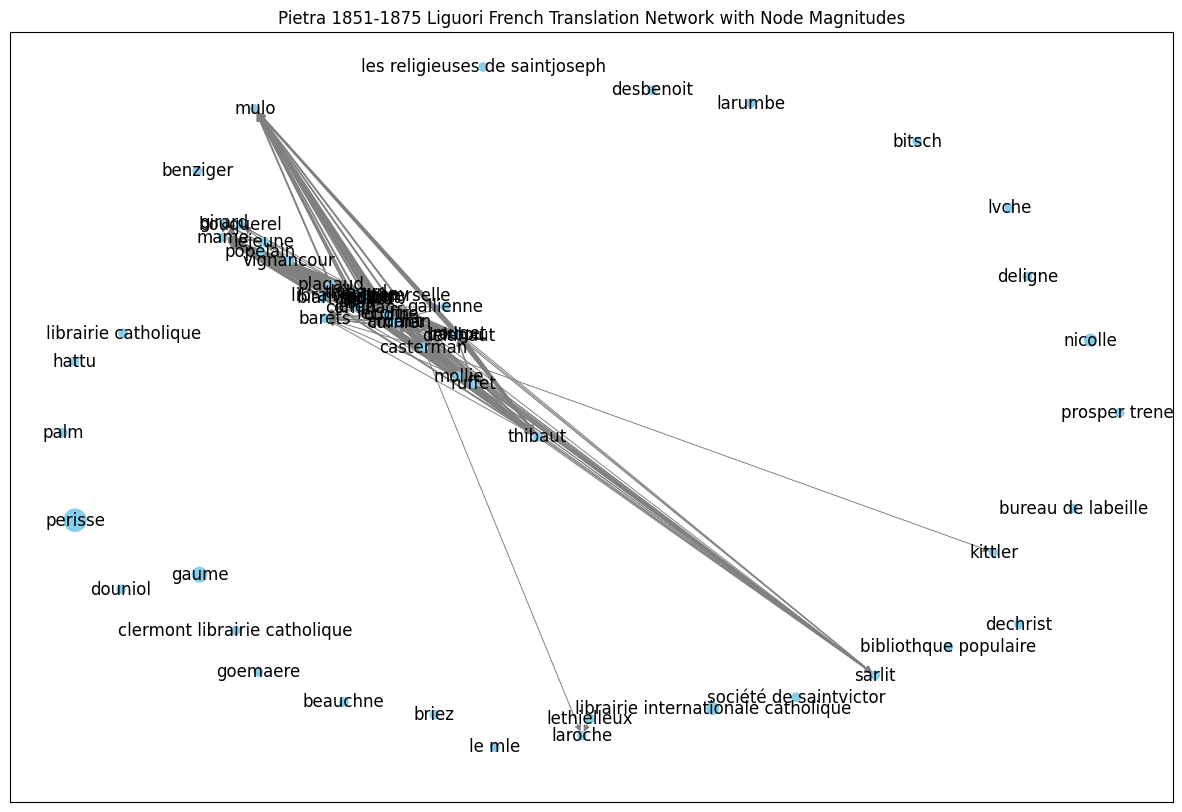

In [14]:

fig, ax = plt.subplots(figsize=(15, 10))

node_sizes = [G_combined.nodes[node].get('magnitude', 1) for node in G_combined.nodes()]

# Scale node sizes for better visualization (adjust scaling factor as needed)
node_sizes = [size * 36 for size in node_sizes]

pos = nx.spring_layout(G_combined)

edge_widths = [np.log(data['weight'] + 1) for _, _, data in G_combined.edges(data=True)]
#edge_widths = [data['weight'] for _, _, data in G_combined.edges(data=True)]

nx.draw_networkx(G_combined, pos, node_size=node_sizes, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths, edge_color='gray', arrows=True)

plt.title("Pietra 1851-1875 Liguori French Translation Network with Node Magnitudes")

plt.savefig('PIETRA_Margento_19th_Cent_Liguori_1851-1875_FR_w_Node_Magnitudes.png')

plt.show()

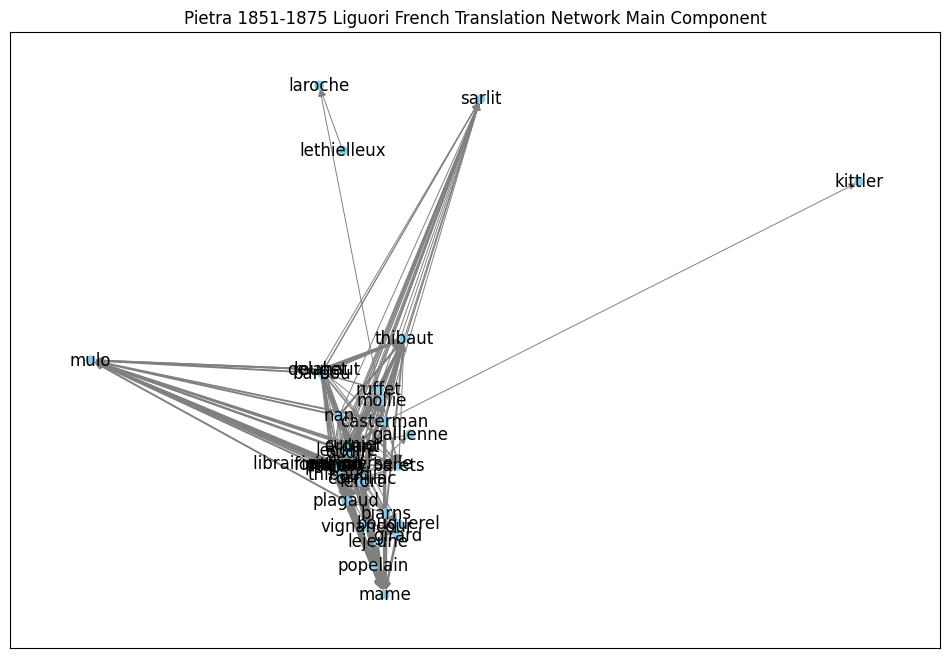

In [15]:

main_component = max(nx.weakly_connected_components(G_combined), key=len)
G_main = G_combined.subgraph(main_component)

node_sizes1 = [G_main.nodes[node].get('magnitude', 1) for node in G_main.nodes()]

node_sizes1 = [size * 36 for size in node_sizes1]

plt.close()

fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(G_main)

edge_widths1 = [np.log(data['weight'] + 1) for _, _, data in G_main.edges(data=True)]

nx.draw_networkx(G_main, pos, node_size=node_sizes1, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths1, edge_color='gray', arrows=True)

plt.title("Pietra 1851-1875 Liguori French Translation Network Main Component")

plt.savefig('Pietra_Margento_Liguori_FR_1851-1875_Main_Component.png')

plt.show()

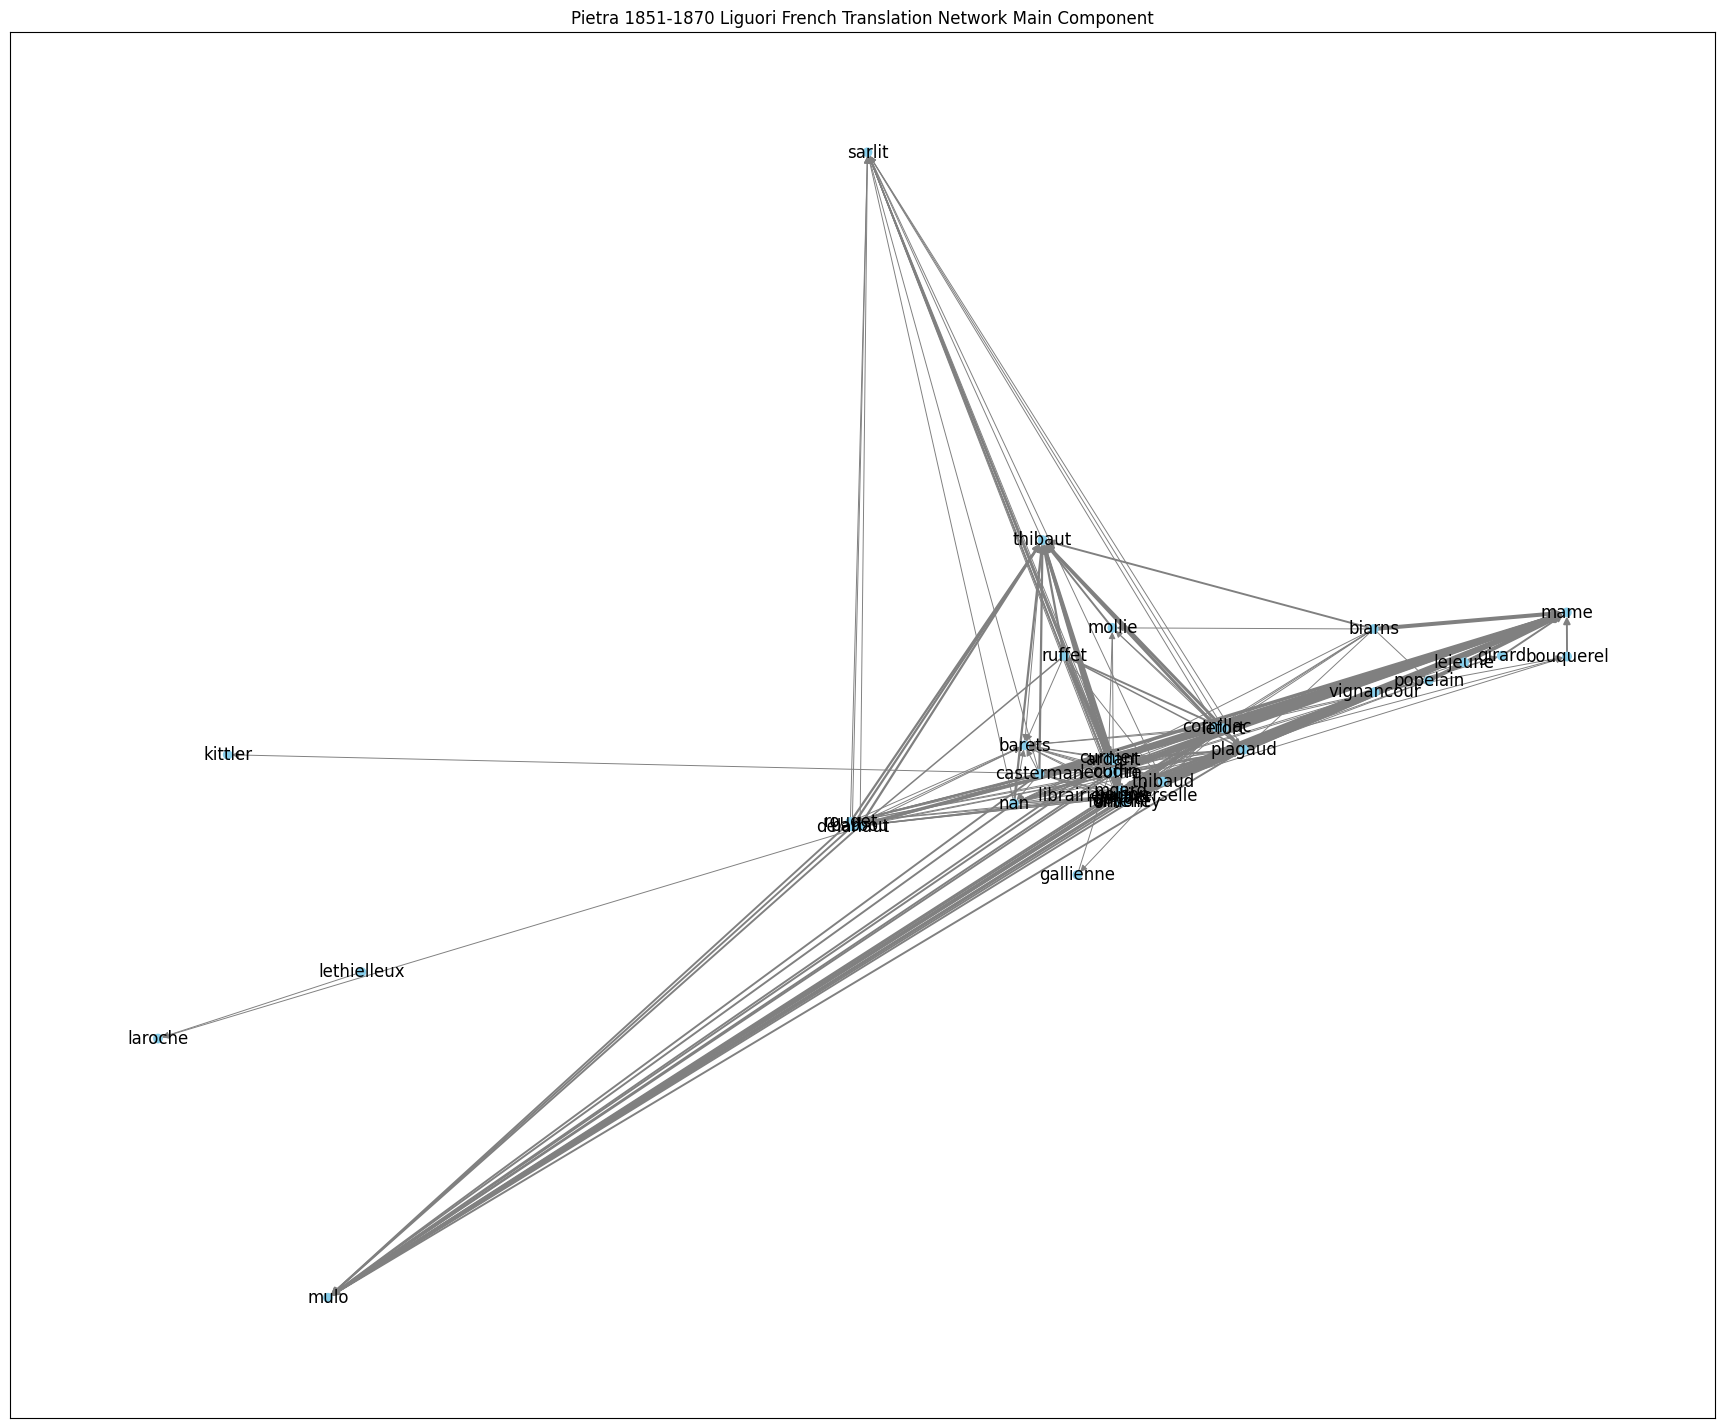

In [16]:

plt.close()

fig, ax = plt.subplots(figsize=(22, 18))

pos = nx.spring_layout(G_main)

edge_widths1 = [np.log(data['weight'] + 1) for _, _, data in G_main.edges(data=True)]

nx.draw_networkx(G_main, pos, node_size=node_sizes1, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths1, edge_color='gray', arrows=True)

plt.title("Pietra 1851-1875 Liguori French Translation Network Main Component")

plt.savefig('Pietra_Margento_Liguori_FR_1851-1875_Main_Component1.png')

plt.show()